<a href="https://colab.research.google.com/github/AdithyaMuralidhara/Object-DetectionYOLOv8/blob/main/ObjectDetction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# ============================================
# Cell 1: Install Ultralytics YOLOv8
# ============================================
!pip install -q ultralytics roboflow

import torch
print(f"🔥 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
print()


🔥 CUDA available: True
   GPU: Tesla T4



In [11]:
# ============================================
# Cell 2: Convert PASCAL VOC to YOLO - 4 Classes (232 Images)
# ============================================
import os
import xml.etree.ElementTree as ET
from google.colab import files
import zipfile
import shutil

print("📤 Upload dataset.zip:")
uploaded = files.upload()

for fn in uploaded.keys():
    with zipfile.ZipFile(fn, 'r') as zip_ref:
        zip_ref.extractall('/content/')

def find_files_recursive(path, extensions):
    files_list = []
    for root, dirs, filenames in os.walk(path):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in extensions):
                files_list.append(os.path.join(root, filename))
    return files_list

all_images = find_files_recursive('/content/dataset', ['.jpg', '.jpeg', '.png'])
all_xmls = find_files_recursive('/content/dataset', ['.xml'])

print(f"\n📊 Found {len(all_images)} images and {len(all_xmls)} XML files")

train_xmls = [x for x in all_xmls if '/train' in x]
test_xmls = [x for x in all_xmls if '/test' in x or '/val' in x]

print(f"   Train: {len(train_xmls)} | Val: {len(test_xmls)}")

def convert_voc_to_yolo_single(xml_path, output_label_path, class_names):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        size = root.find('size')
        if size is None:
            return False

        img_width = float(size.find('width').text)
        img_height = float(size.find('height').text)

        yolo_annotations = []

        for obj in root.findall('object'):
            name_elem = obj.find('name')
            if name_elem is None:
                continue

            class_name = name_elem.text.lower()
            if class_name not in class_names:
                continue

            class_id = class_names.index(class_name)

            bbox = obj.find('bndbox')
            if bbox is None:
                continue

            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)

            if xmin >= xmax or ymin >= ymax:
                continue

            x_center = ((xmin + xmax) / 2) / img_width
            y_center = ((ymin + ymax) / 2) / img_height
            width = (xmax - xmin) / img_width
            height = (ymax - ymin) / img_height

            if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 < width <= 1 and 0 < height <= 1):
                continue

            yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        if yolo_annotations:
            with open(output_label_path, 'w') as f:
                f.write('\n'.join(yolo_annotations))
            return True
        return False
    except:
        return False

os.makedirs('/content/yolo_dataset/train/images', exist_ok=True)
os.makedirs('/content/yolo_dataset/train/labels', exist_ok=True)
os.makedirs('/content/yolo_dataset/valid/images', exist_ok=True)
os.makedirs('/content/yolo_dataset/valid/labels', exist_ok=True)

class_names = ['mouse', 'screwdriver', 'sharpener', 'pen']
print(f"\n📋 Classes: {class_names}\n")

train_converted = 0
train_stats = {cls: 0 for cls in class_names}

for xml_path in train_xmls:
    base_name = os.path.splitext(os.path.basename(xml_path))[0]
    matching_images = [img for img in all_images if base_name in os.path.basename(img) and '/train' in img]

    if not matching_images:
        continue

    img_path = matching_images[0]
    label_path = f'/content/yolo_dataset/train/labels/{base_name}.txt'

    if convert_voc_to_yolo_single(xml_path, label_path, class_names):
        shutil.copy(img_path, f'/content/yolo_dataset/train/images/{os.path.basename(img_path)}')
        train_converted += 1

        with open(label_path, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                train_stats[class_names[class_id]] += 1

test_converted = 0
test_stats = {cls: 0 for cls in class_names}

for xml_path in test_xmls:
    base_name = os.path.splitext(os.path.basename(xml_path))[0]
    matching_images = [img for img in all_images if base_name in os.path.basename(img) and ('/test' in img or '/val' in img)]

    if not matching_images:
        continue

    img_path = matching_images[0]
    label_path = f'/content/yolo_dataset/valid/labels/{base_name}.txt'

    if convert_voc_to_yolo_single(xml_path, label_path, class_names):
        shutil.copy(img_path, f'/content/yolo_dataset/valid/images/{os.path.basename(img_path)}')
        test_converted += 1

        with open(label_path, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                test_stats[class_names[class_id]] += 1

print("="*60)
print("✅ CONVERSION COMPLETE")
print("="*60)
print(f"\nTrain: {train_converted} images | Valid: {test_converted} images")
print(f"\n📊 Training Set:")
for cls, count in train_stats.items():
    print(f"  {cls:12s}: {count:3d} objects")
print(f"\n📊 Validation Set:")
for cls, count in test_stats.items():
    print(f"  {cls:12s}: {count:3d} objects")
print("="*60)


📤 Upload dataset.zip:


Saving dataset.zip to dataset (1).zip

📊 Found 225 images and 225 XML files
   Train: 180 | Val: 45

📋 Classes: ['mouse', 'screwdriver', 'sharpener', 'pen']

✅ CONVERSION COMPLETE

Train: 180 images | Valid: 45 images

📊 Training Set:
  mouse       :  51 objects
  screwdriver :  90 objects
  sharpener   :  25 objects
  pen         :  36 objects

📊 Validation Set:
  mouse       :  26 objects
  screwdriver :  19 objects
  sharpener   :  18 objects
  pen         :  19 objects


In [12]:
# ============================================
# Cell 3: Create dataset.yaml
# ============================================
import yaml

dataset_config = {
    'path': '/content/yolo_dataset',
    'train': 'train/images',
    'val': 'valid/images',
    'nc': 4,
    'names': ['mouse', 'screwdriver', 'sharpener', 'pen']
}

with open('/content/yolo_dataset/dataset.yaml', 'w') as f:
    yaml.dump(dataset_config, f)

print("✅ Dataset configuration created!")
!cat /content/yolo_dataset/dataset.yaml


✅ Dataset configuration created!
names:
- mouse
- screwdriver
- sharpener
- pen
nc: 4
path: /content/yolo_dataset
train: train/images
val: valid/images


In [13]:
# ============================================
# Cell 4: Train YOLOv8n - 320x320 for Pi 4B Speed
# ============================================
from ultralytics import YOLO
import torch

print(f"🔥 GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}\n")

model = YOLO('yolov8n.pt')

# OPTIMIZED FOR SPEED: 320x320 input
results = model.train(
    data='/content/yolo_dataset/dataset.yaml',

    # Speed-optimized settings
    epochs=250,              # Sufficient for 232 images
    imgsz=320,              # KEY: 320x320 for Pi 4B (was 416)
    batch=16 if torch.cuda.is_available() else 4,
    patience=40,

    # Balanced augmentation
    augment=True,
    hsv_h=0.02,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=15.0,
    translate=0.1,
    scale=0.6,
    fliplr=0.5,
    flipud=0.0,
    mosaic=0.8,
    mixup=0.08,
    copy_paste=0.0,

    # Multi-scale disabled for consistent 320x320
    multi_scale=False,

    # Optimizer
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    warmup_epochs=3.0,

    # Loss weights
    box=7.5,
    cls=0.6,              # Slightly higher for 4 classes
    dfl=1.5,

    # Performance
    device=0 if torch.cuda.is_available() else 'cpu',
    workers=8,
    amp=True,
    cache=True,

    # Training stability
    close_mosaic=15,

    # Output
    project='runs/detect',
    name='train_320_4class',
    exist_ok=False,

    # Validation
    val=True,
    plots=True,
    save=True
)

print("\n" + "="*60)
print("✅ TRAINING COMPLETE (320x320)")
print("="*60)
print(f"📂 Model: {results.save_dir}/weights/best.pt")
print("="*60)


🔥 GPU: Tesla T4

Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=15, cls=0.6, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/dataset.yaml, degrees=15.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.08, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=train_320_4class3, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=40, pe

Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 975.1±39.3 MB/s, size: 534.7 KB)
val: Scanning /content/yolo_dataset/valid/labels.cache... 41 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 41/41 80.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.8it/s 1.6s
                   all         41         76      0.844      0.854      0.874      0.567
                 mouse         23         23      0.909      0.826       0.95      0.654
           screwdriver         18         18      0.688      0.983      0.754       0.46
             sharpener         17         17      0.934      0.828      0.967      0.742
                   pen         18         18      0.846      0.778      0.826      0.414
Speed: 2.1ms preprocess, 2.6ms inference, 0.0ms lo

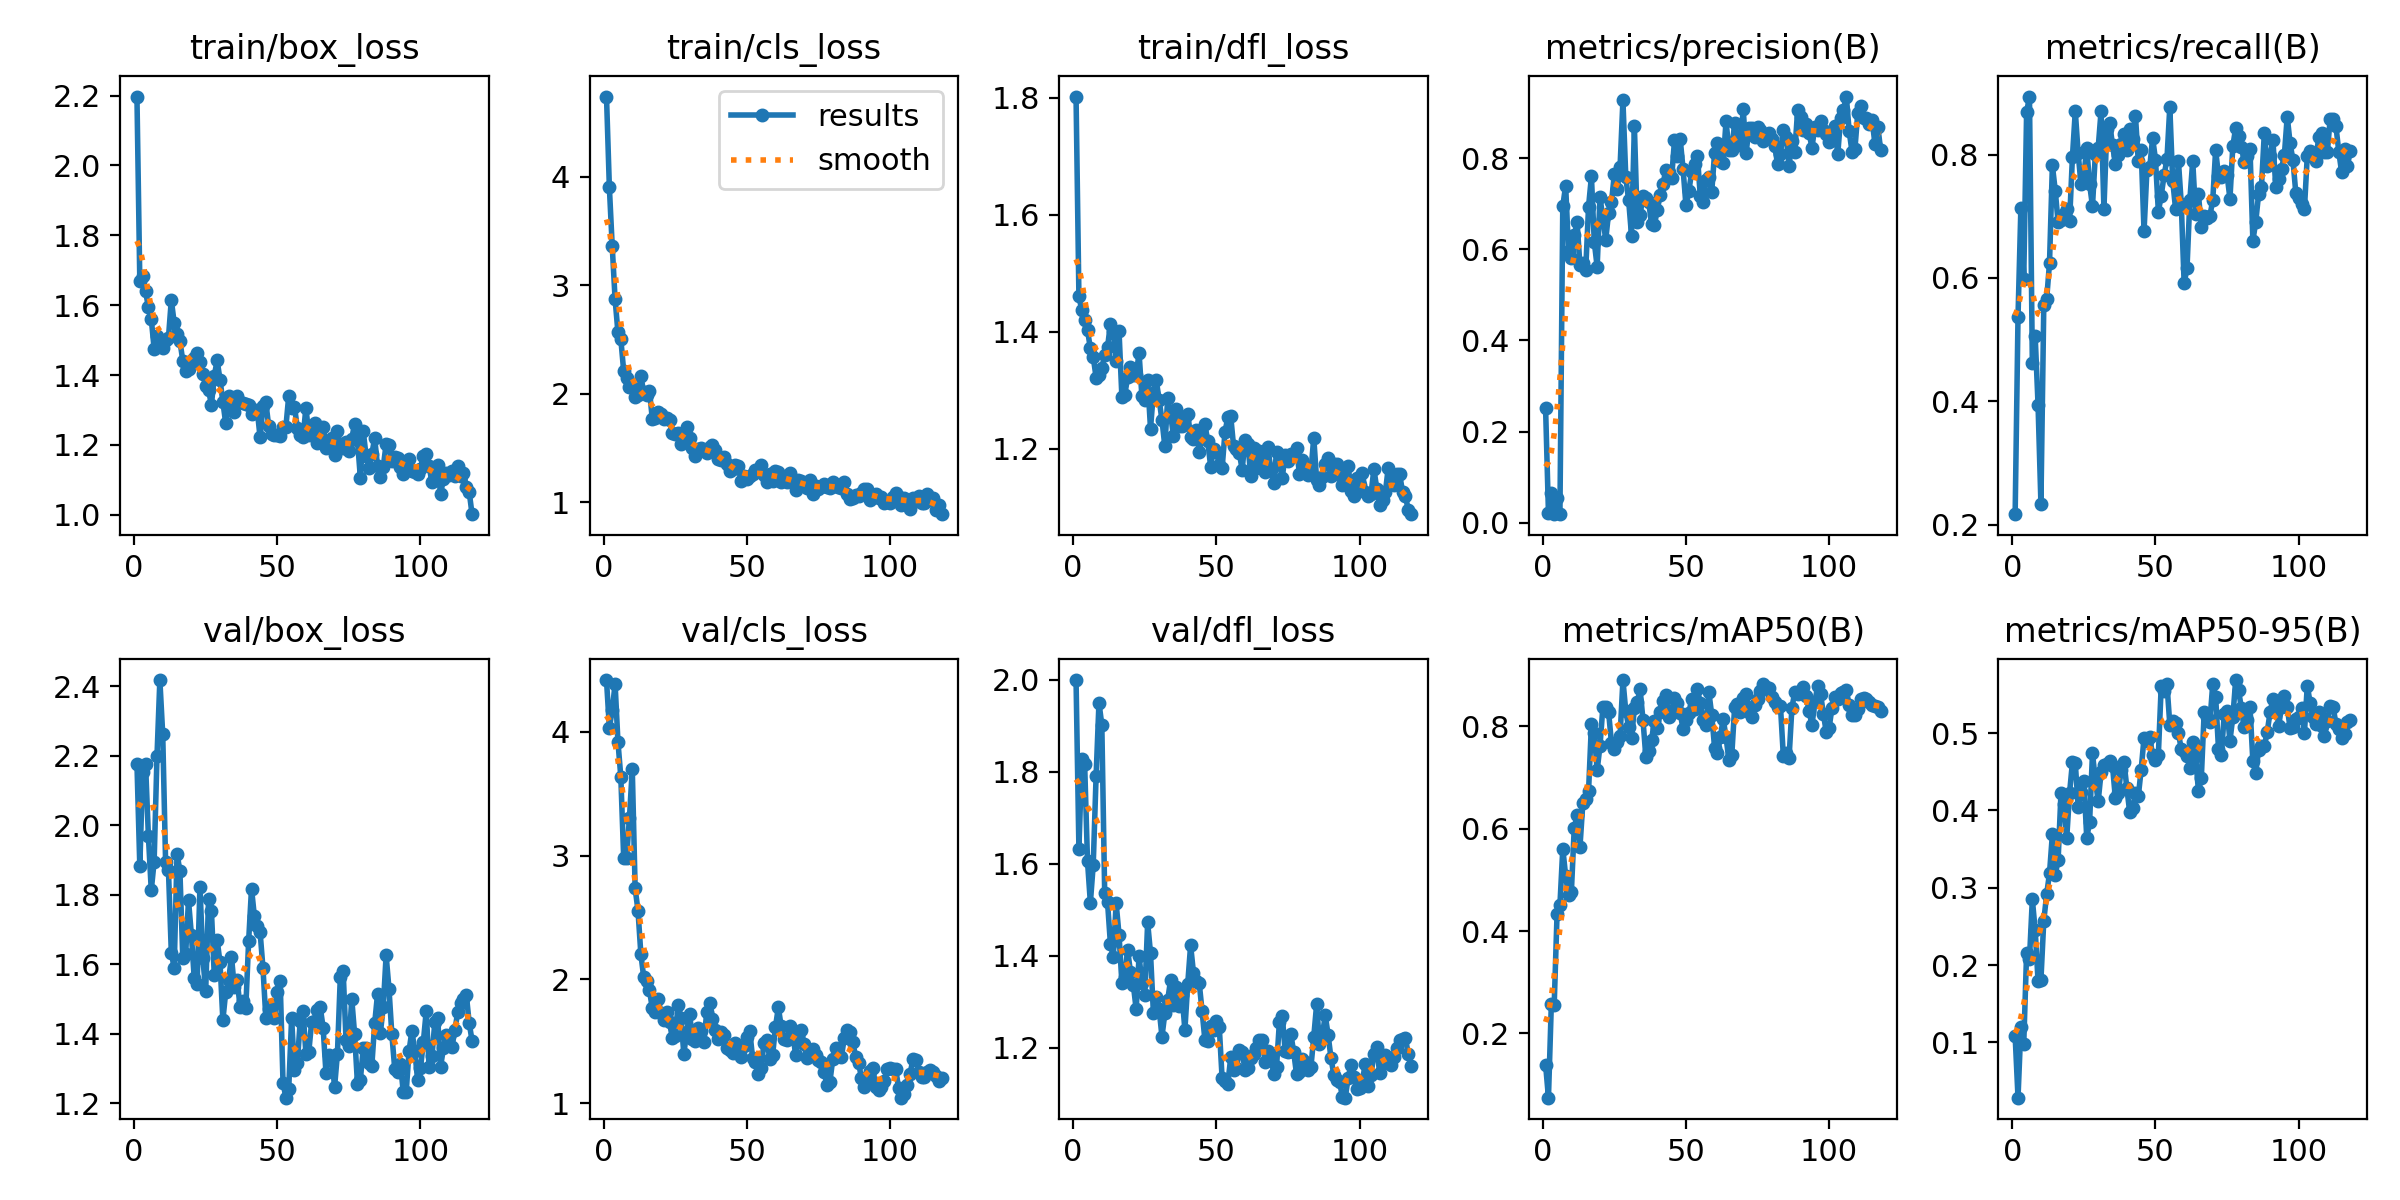


🎭 Confusion Matrix:


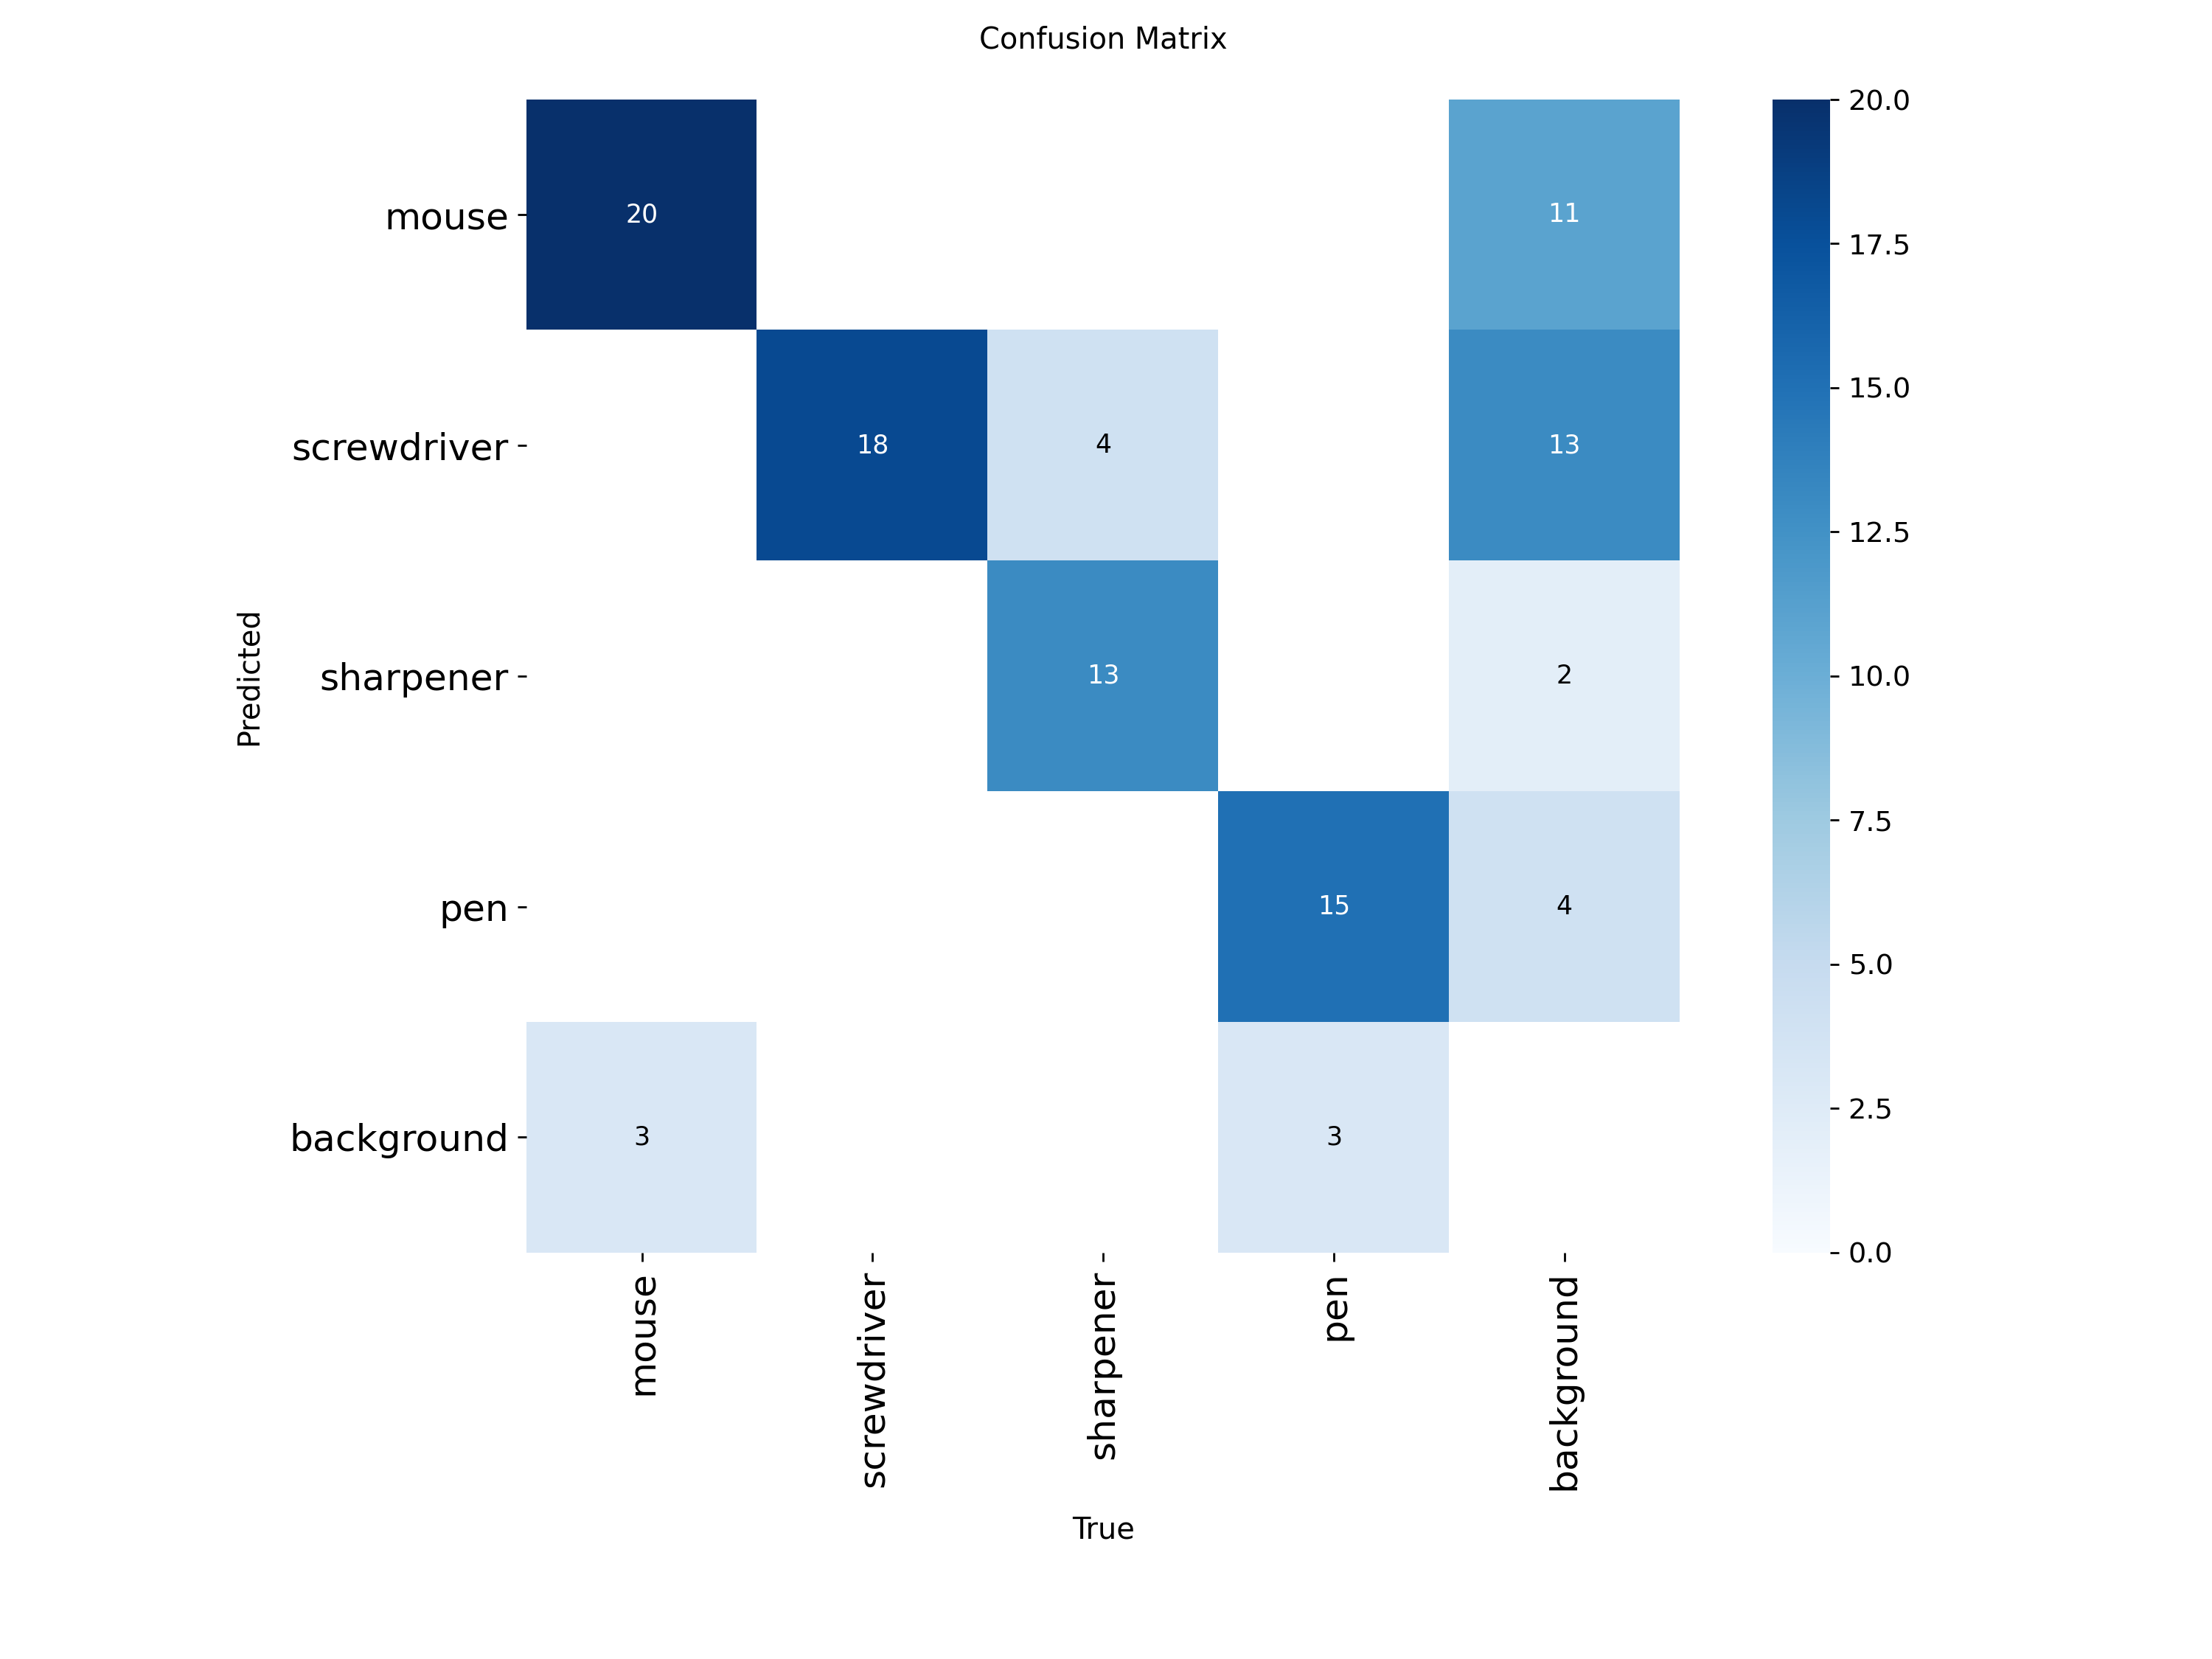

In [14]:
# ============================================
# Cell 5: Evaluate Performance
# ============================================
from IPython.display import Image, display

metrics = model.val()

print("\n" + "="*60)
print("📊 VALIDATION RESULTS (320x320)")
print("="*60)
print(f"\n🎯 Overall:")
print(f"  mAP@50    : {metrics.box.map50:.1%}")
print(f"  mAP@50-95 : {metrics.box.map:.1%}")
print(f"  Precision : {metrics.box.mp:.1%}")
print(f"  Recall    : {metrics.box.mr:.1%}")

class_names = ['mouse', 'screwdriver', 'sharpener', 'pen']
if hasattr(metrics.box, 'maps'):
    print(f"\n📦 Per-Class mAP@50:")
    for name, map50 in zip(class_names, metrics.box.maps):
        print(f"  {name:12s}: {map50:.1%}")

print("\n" + "="*60)

print("\n📈 Training Results:")
display(Image(filename=f'{results.save_dir}/results.png'))

print("\n🎭 Confusion Matrix:")
display(Image(filename=f'{results.save_dir}/confusion_matrix.png'))


📷 All8.jpg

image 1/1 /content/yolo_dataset/valid/images/All8.jpg: 320x256 1 screwdriver, 1 sharpener, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 256)
Results saved to /content/runs/detect/predict2
  ✓ sharpener   : 61.4%
  ✓ screwdriver : 61.2%

📷 All18.jpg

image 1/1 /content/yolo_dataset/valid/images/All18.jpg: 320x256 1 screwdriver, 1 sharpener, 1 pen, 5.3ms
Speed: 0.9ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 256)
Results saved to /content/runs/detect/predict2
  ✓ sharpener   : 79.2%
  ✓ pen         : 64.2%
  ✓ screwdriver : 62.6%

📷 mouse12.jpg

image 1/1 /content/yolo_dataset/valid/images/mouse12.jpg: 256x320 1 mouse, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 320)
Results saved to /content/runs/detect/predict2
  ✓ mouse       : 59.8%

📷 mouse25.jpg

image 1/1 /content/yolo_dataset/valid/images/mouse25.jpg: 256x320 1 mouse, 6.5ms
Spe

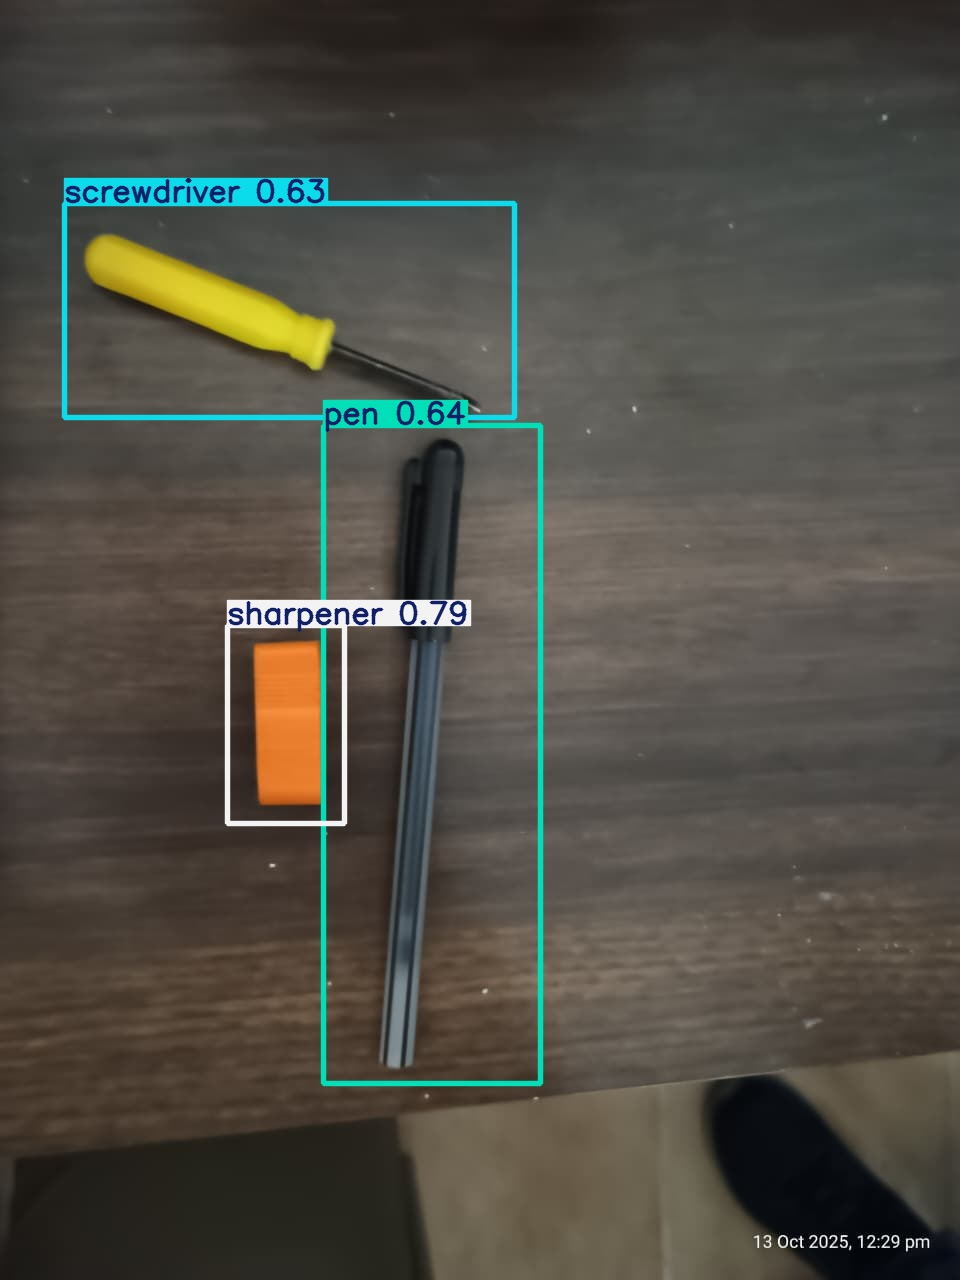

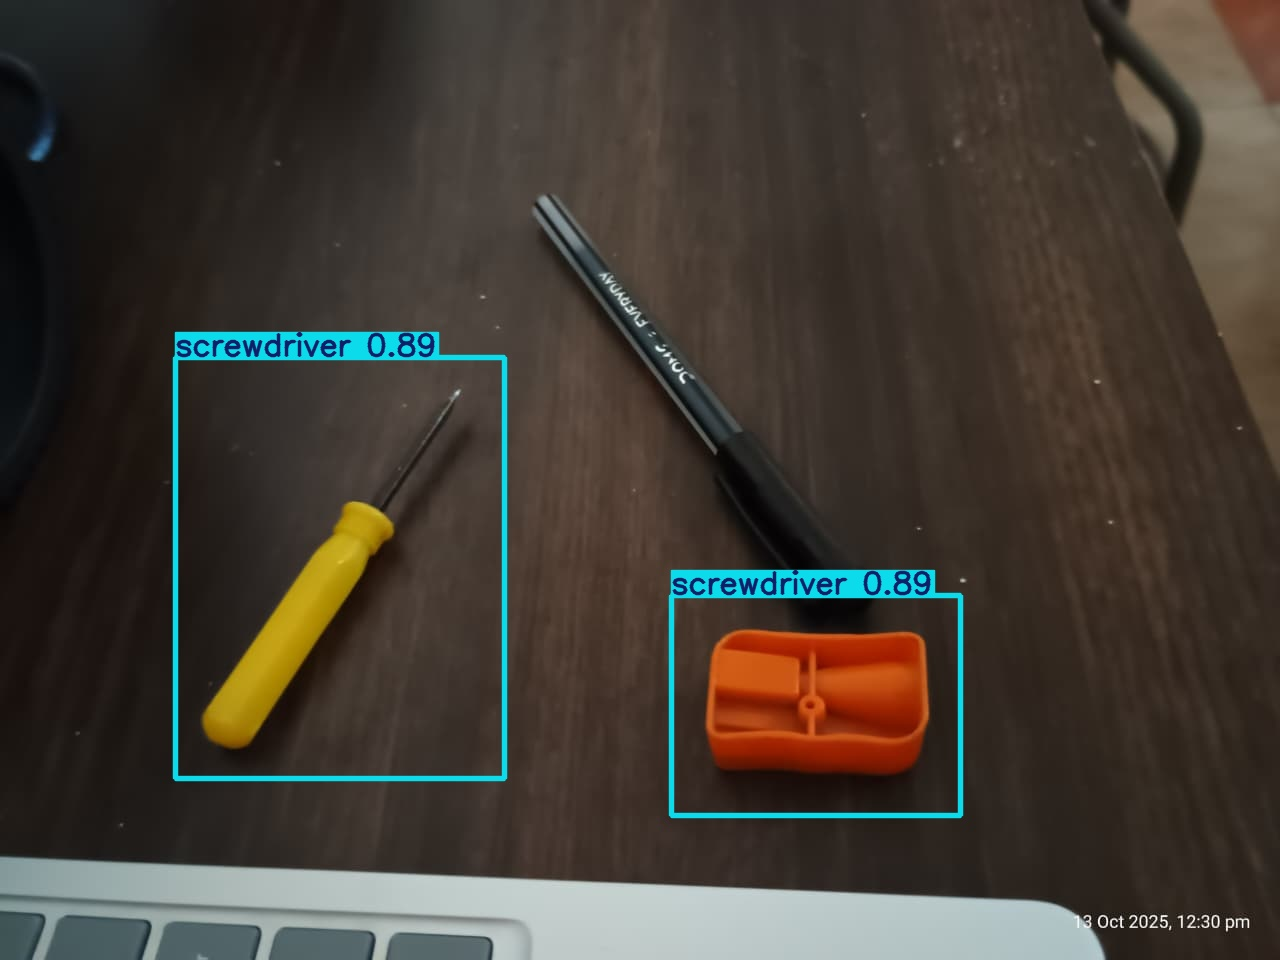

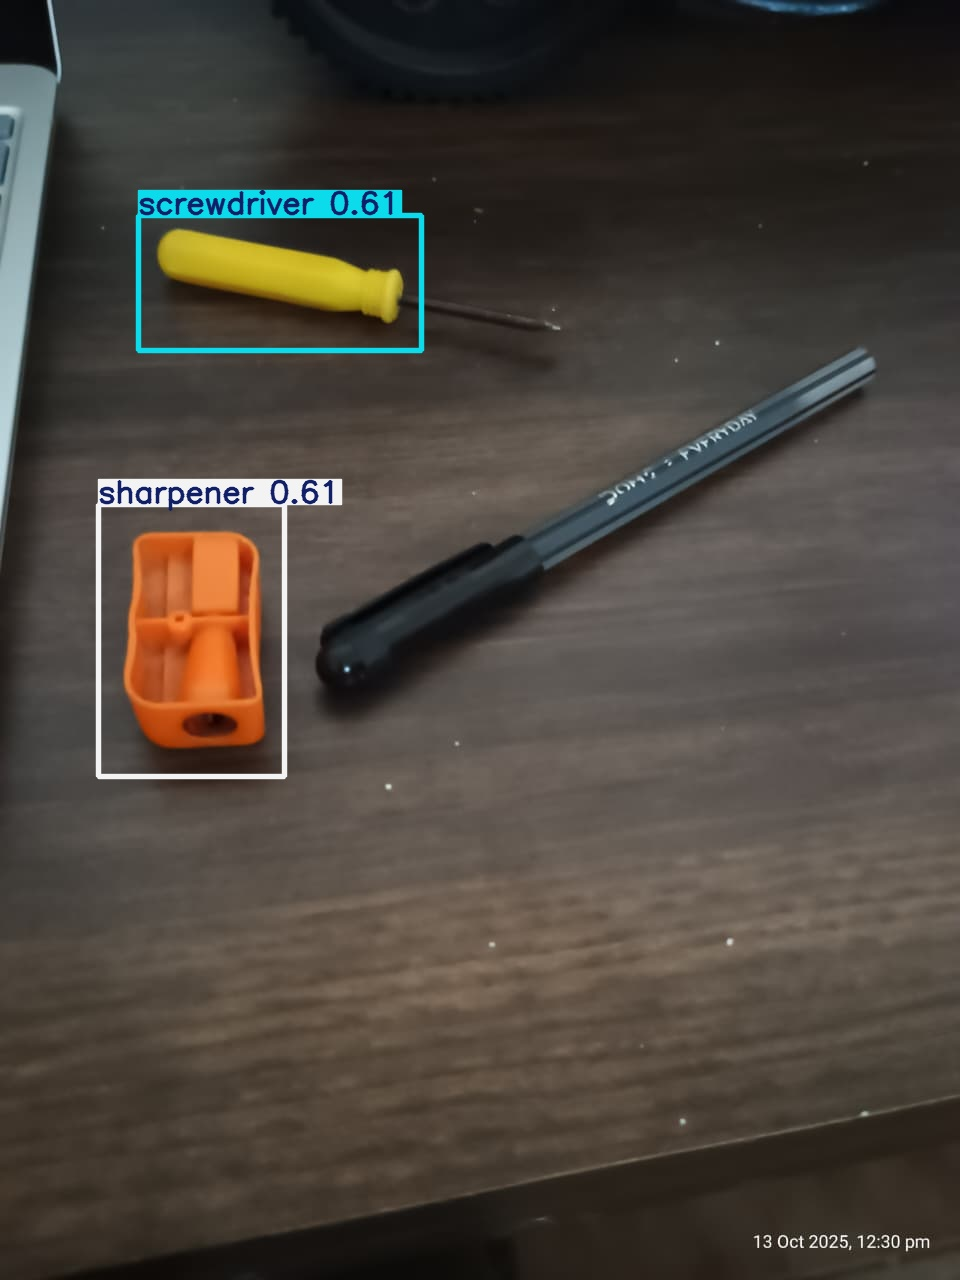

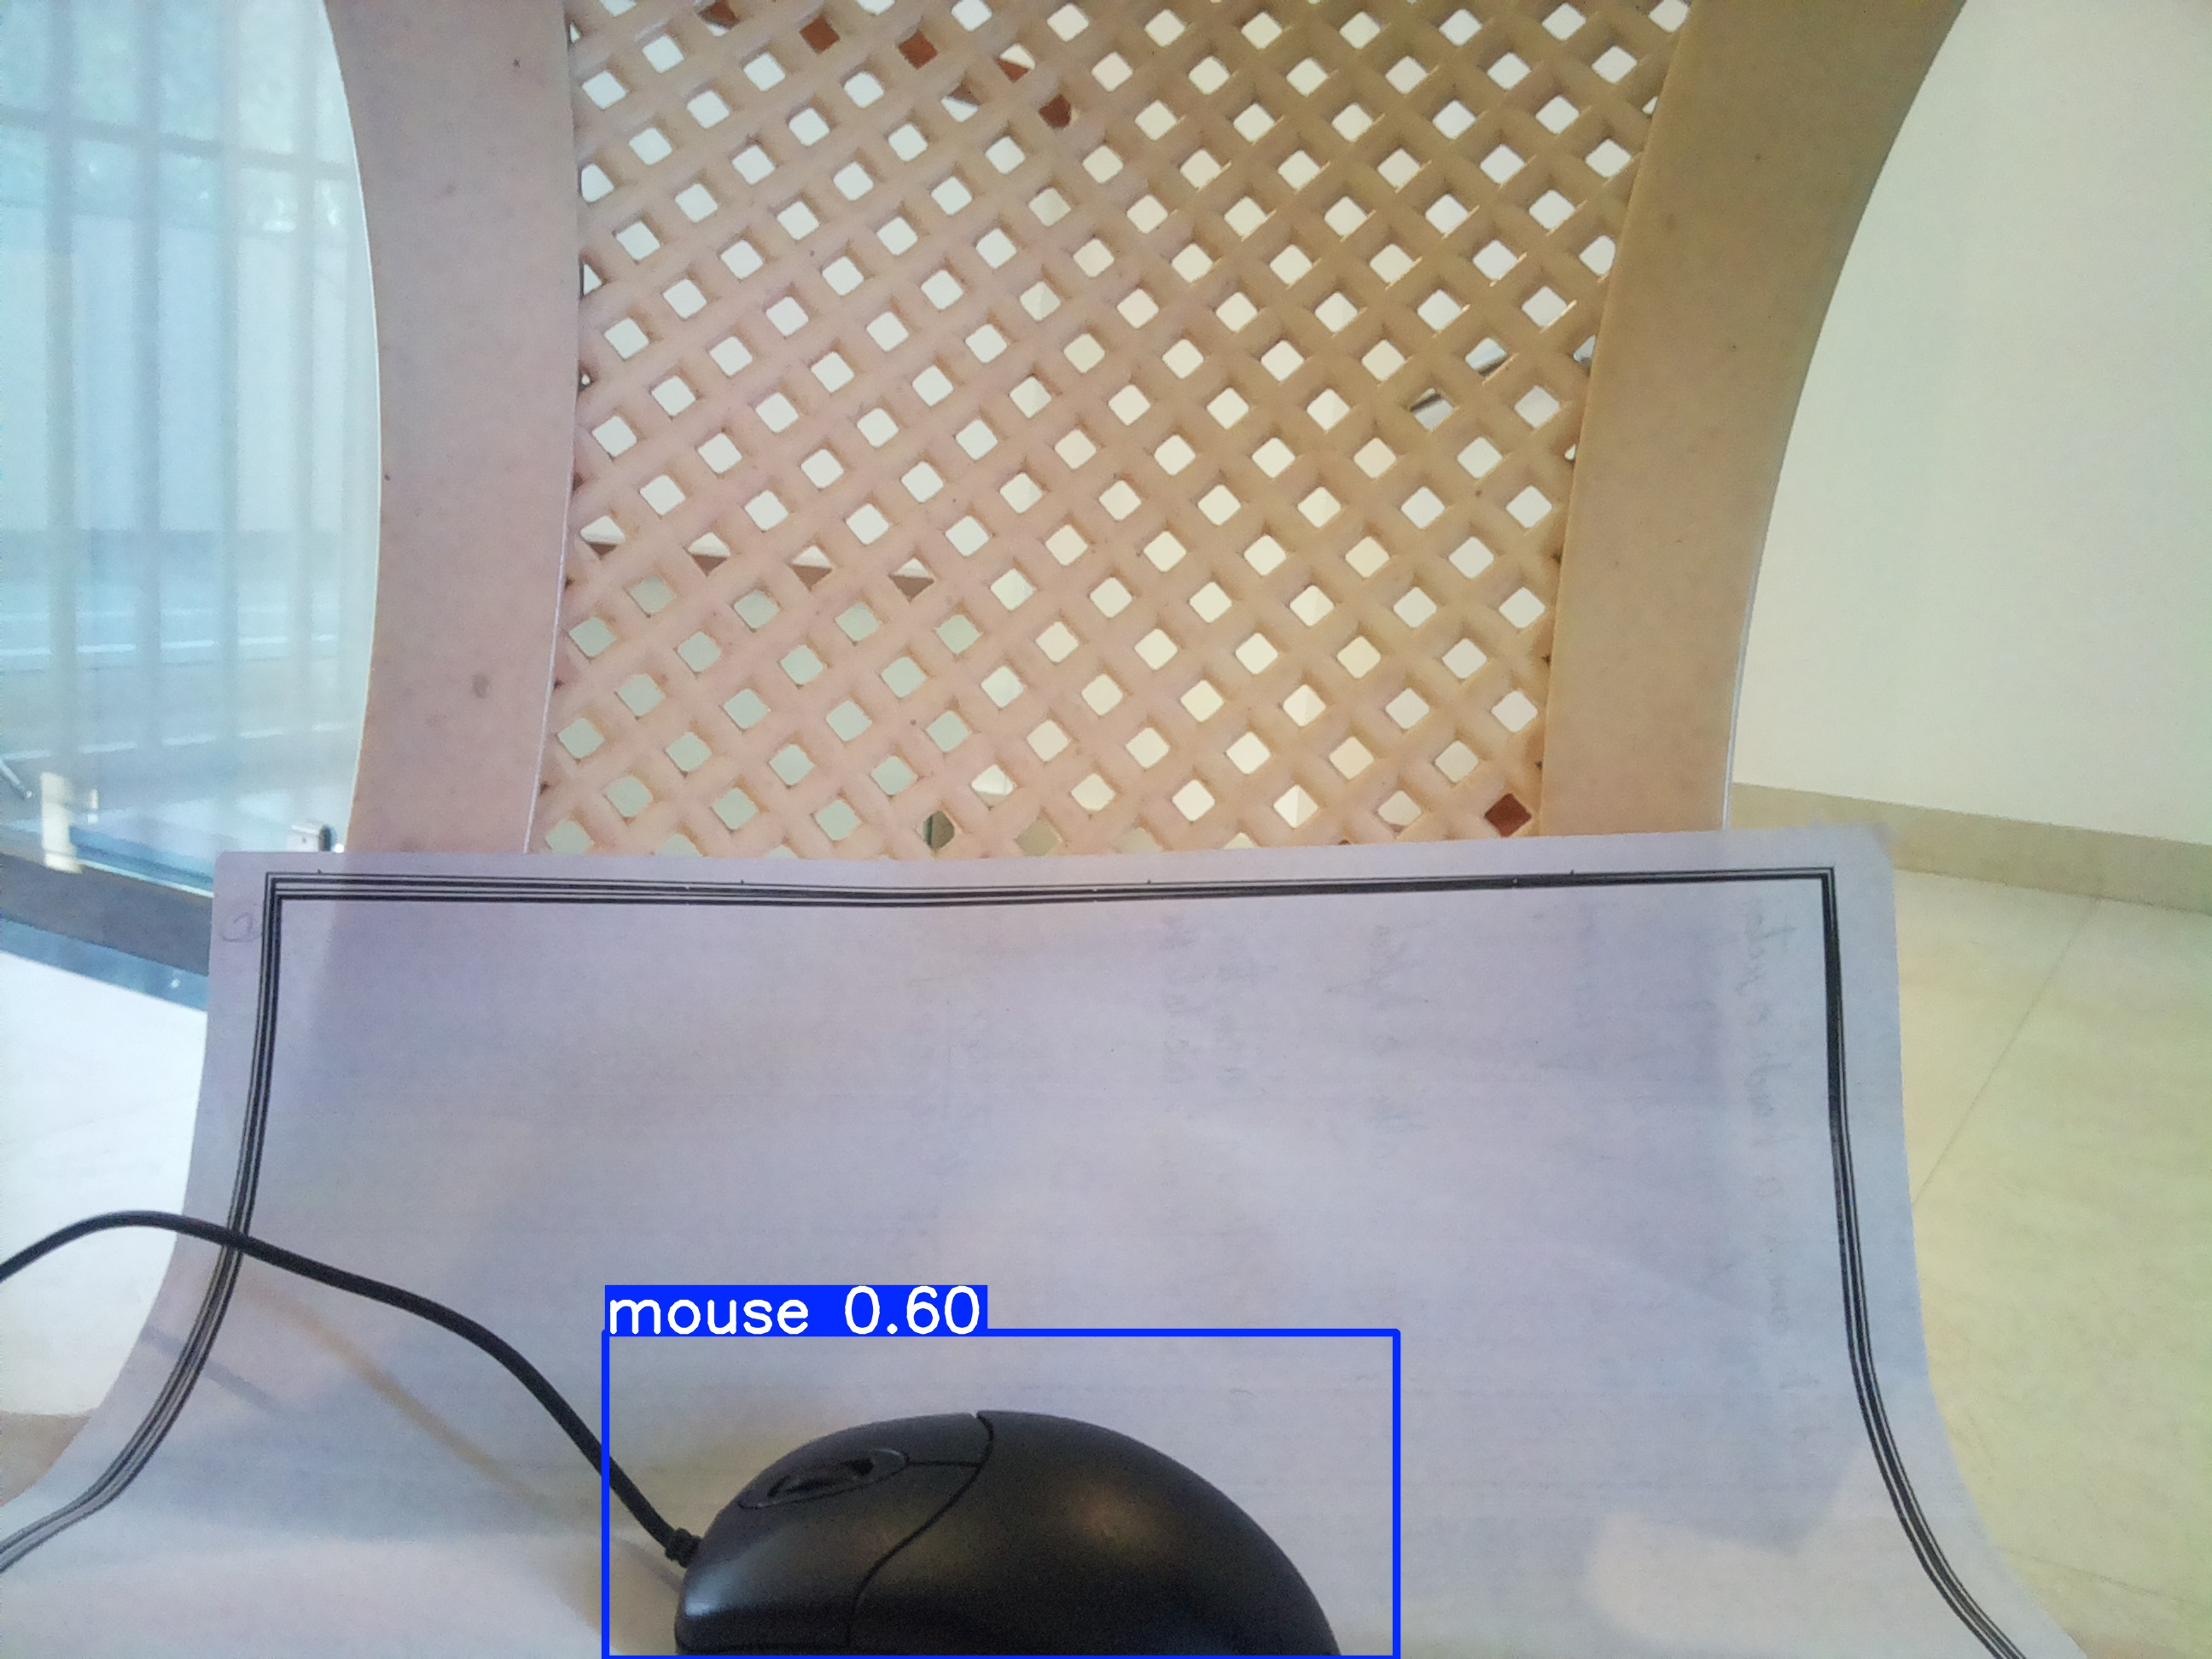

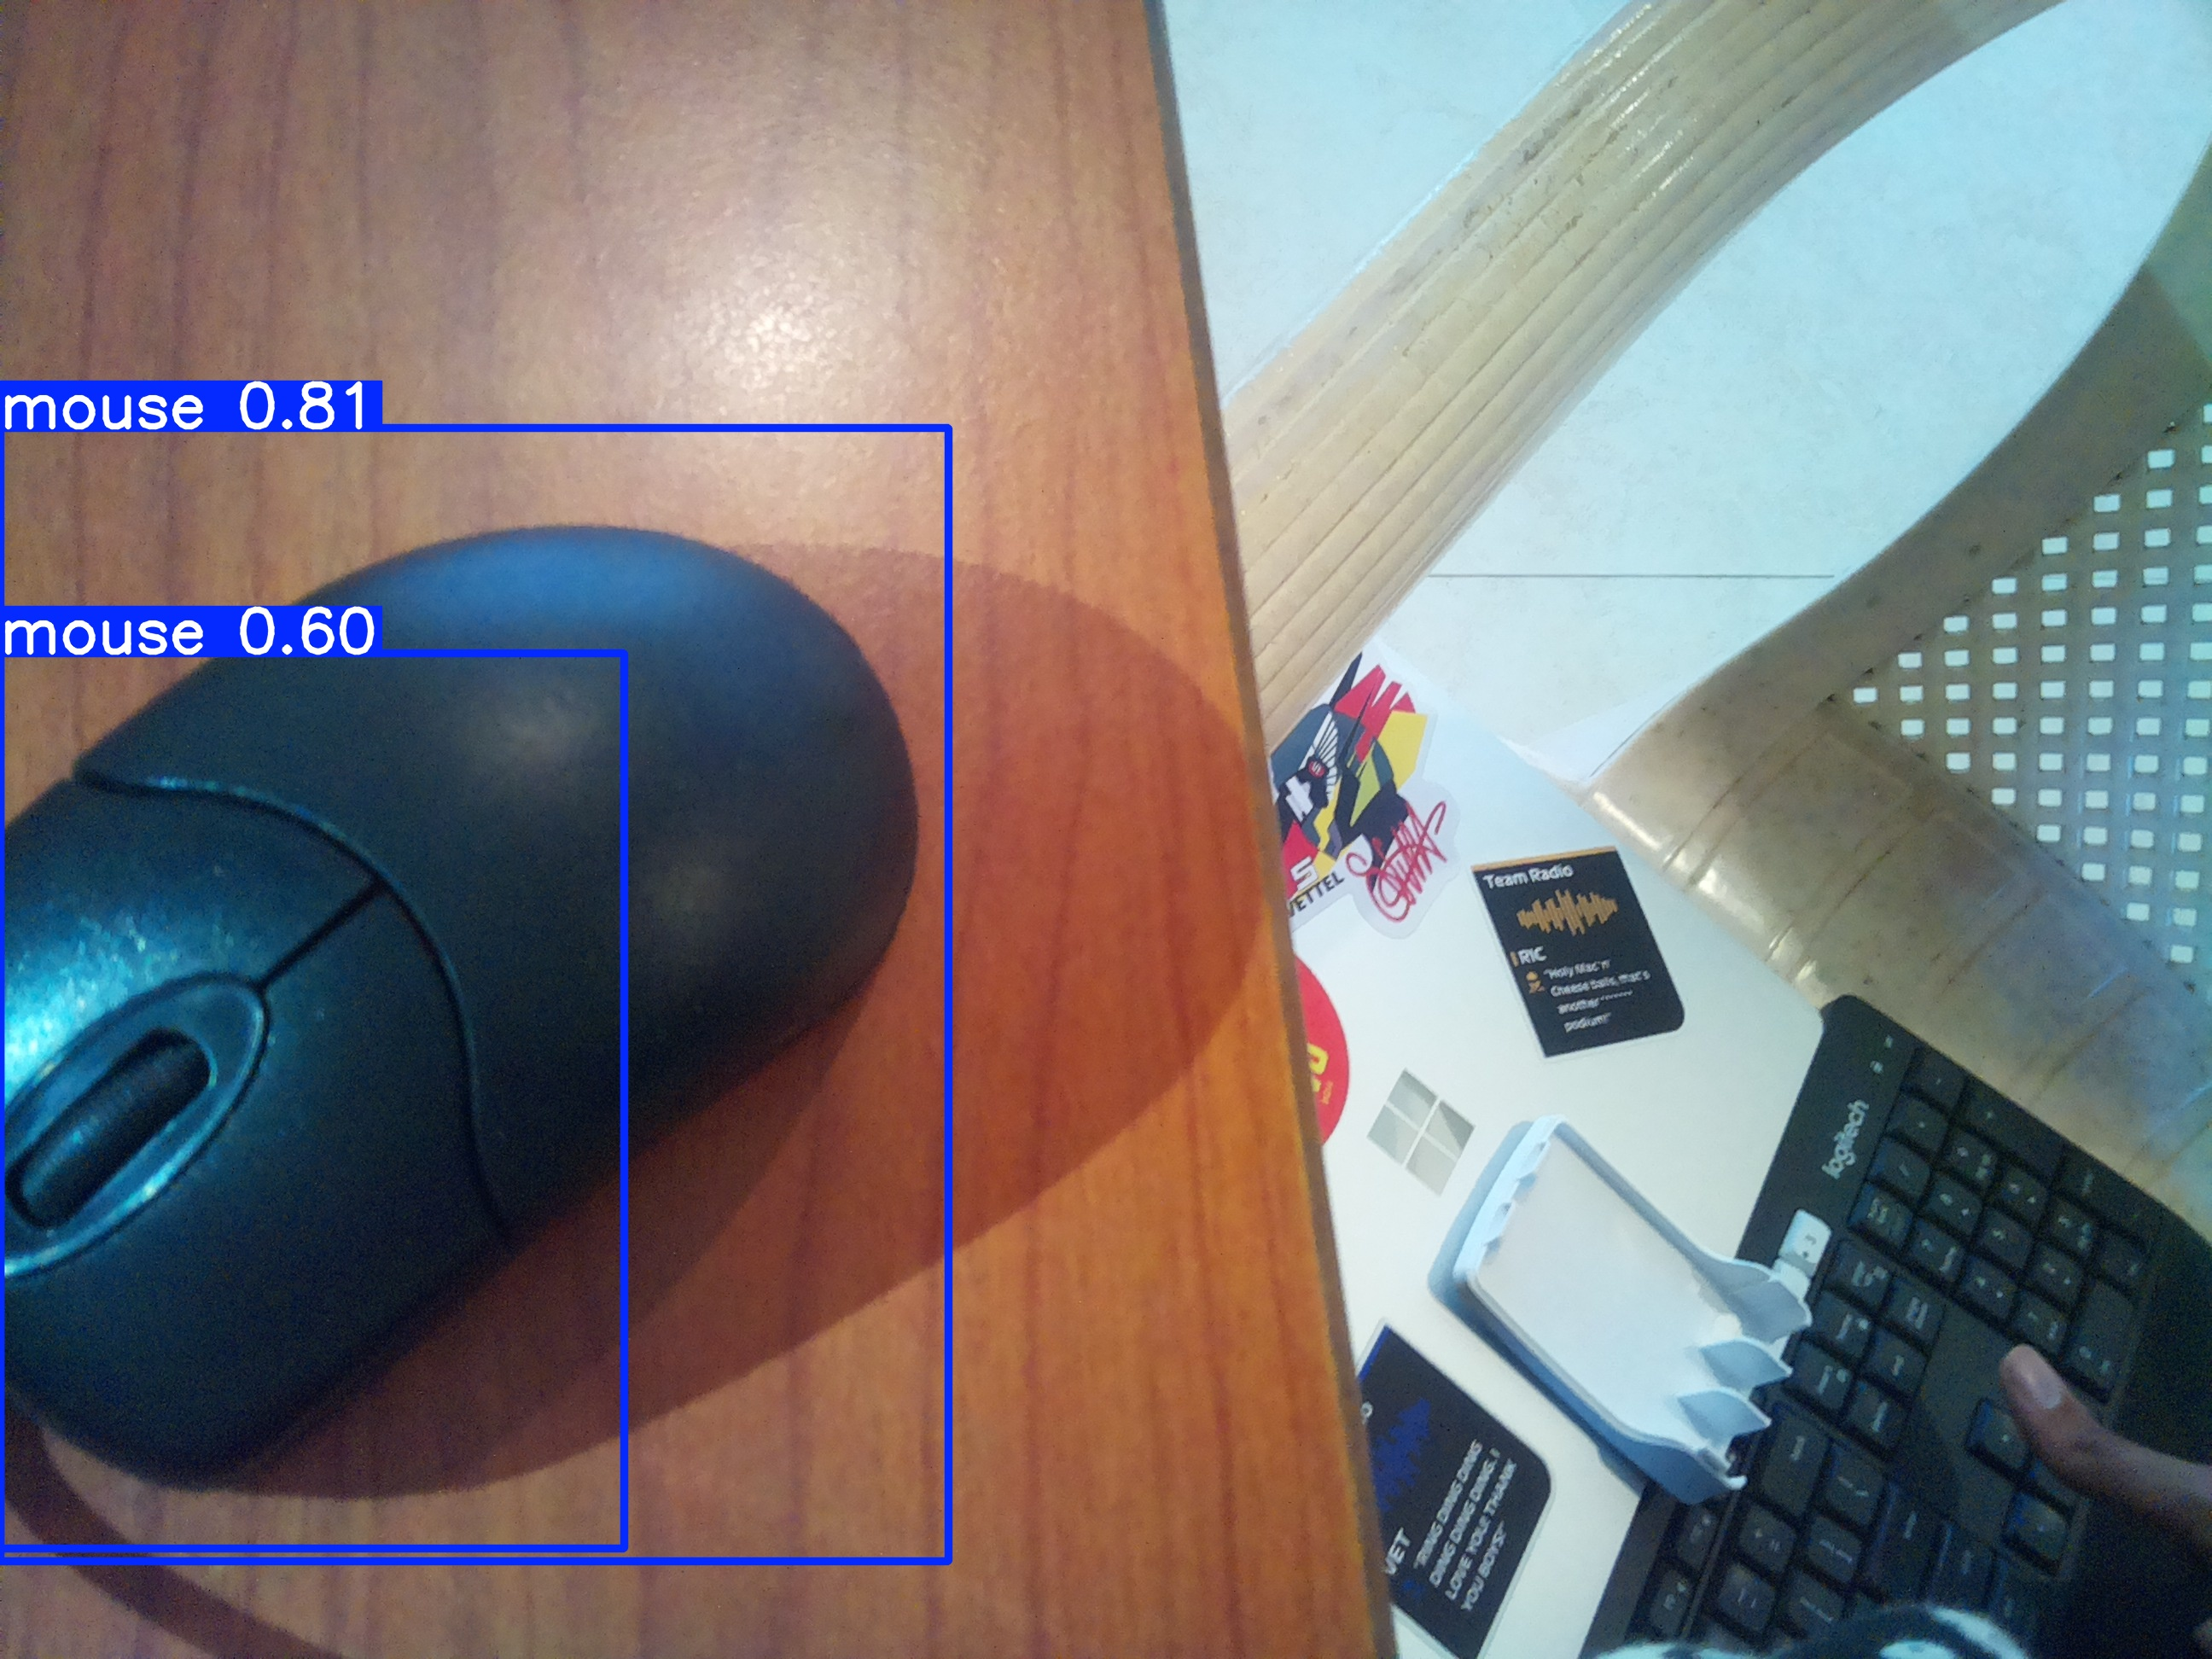

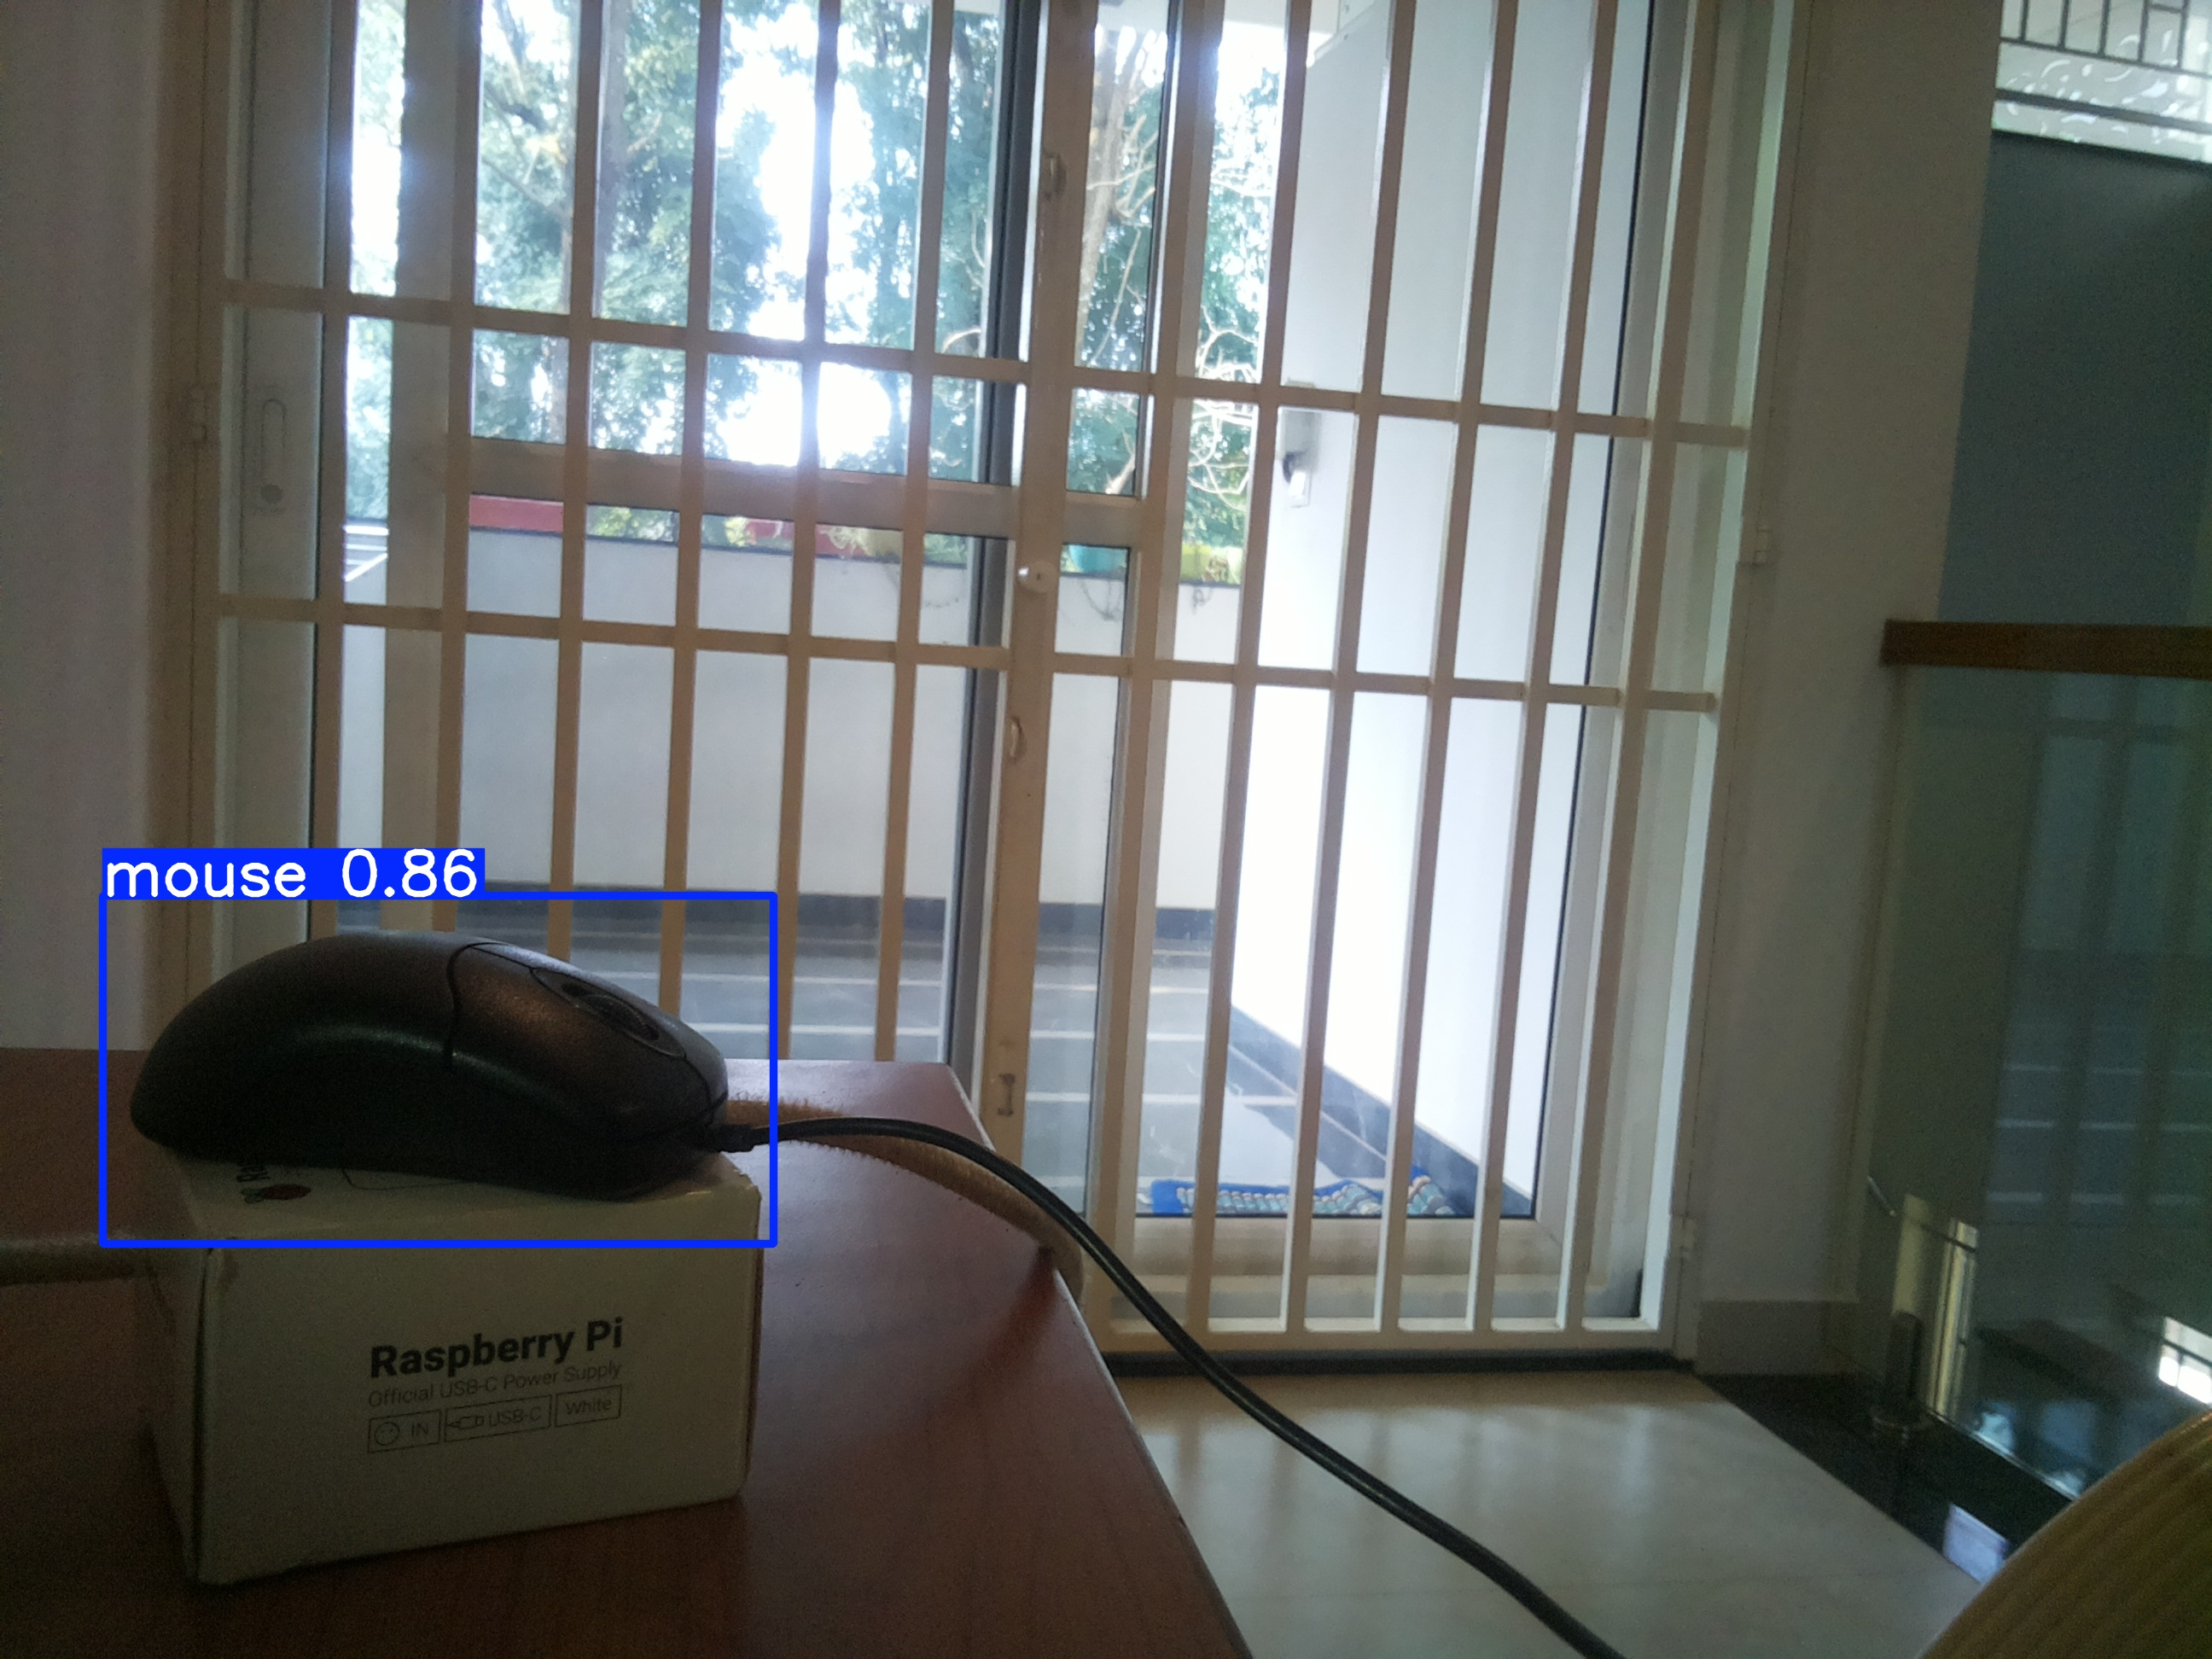

In [15]:
# ============================================
# Cell 6: Test Predictions
# ============================================
from IPython.display import Image, display
import glob
import random

val_images = glob.glob('/content/yolo_dataset/valid/images/*')
samples = random.sample(val_images, min(6, len(val_images)))

class_names = ['mouse', 'screwdriver', 'sharpener', 'pen']

for img_path in samples:
    print(f"📷 {img_path.split('/')[-1]}")

    results_pred = model.predict(
        source=img_path,
        save=True,
        conf=0.5,
        imgsz=320,
        device=0 if torch.cuda.is_available() else 'cpu'
    )

    if len(results_pred[0].boxes) > 0:
        for box in results_pred[0].boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            print(f"  ✓ {class_names[cls_id]:12s}: {conf:.1%}")
    else:
        print("  ⚪ None")
    print()

print("\n🖼️ Sample Predictions:")
pred_imgs = sorted(glob.glob(f'{results_pred[0].save_dir}/*.jpg'))[:6]
for img in pred_imgs:
    display(Image(filename=img, width=640))


In [16]:
# ============================================
# Cell 7: Export to TFLite INT8 (320x320) - FIXED
# ============================================
from google.colab import files
import os
import glob

print("⚙️ Exporting to TFLite INT8...\n")

model.export(
    format='tflite',
    imgsz=320,
    int8=True,
    data='/content/yolo_dataset/dataset.yaml',
    nms=False
)

# FIXED: Find the model regardless of folder name
tflite_files = glob.glob('/content/runs/detect/train_320_4class*/weights/best_saved_model/best_int8.tflite')

if not tflite_files:
    print("❌ Model not found. Searching all .tflite files...")
    !find /content/runs -name "best_int8.tflite"
    exit()

# Use the most recent one
tflite_model = sorted(tflite_files)[-1]
model_size = os.path.getsize(tflite_model) / (1024*1024)

print(f"✅ Found model: {tflite_model}")
print(f"   Size: {model_size:.2f} MB\n")

# Get the training folder name dynamically
train_folder = os.path.dirname(os.path.dirname(os.path.dirname(tflite_model)))
print(f"📂 Training folder: {train_folder}\n")

print("📦 Creating deployment package...\n")

!mkdir -p /content/object_detector_320

# Copy files using the found model path
import shutil
shutil.copy(tflite_model, '/content/object_detector_320/model.tflite')
shutil.copy('/content/yolo_dataset/dataset.yaml', '/content/object_detector_320/')

# Copy training results (check if files exist)
results_png = os.path.join(train_folder, 'results.png')
confusion_png = os.path.join(train_folder, 'confusion_matrix.png')
labels_jpg = os.path.join(train_folder, 'labels.jpg')

if os.path.exists(results_png):
    shutil.copy(results_png, '/content/object_detector_320/training_results.png')
if os.path.exists(confusion_png):
    shutil.copy(confusion_png, '/content/object_detector_320/confusion_matrix.png')
if os.path.exists(labels_jpg):
    shutil.copy(labels_jpg, '/content/object_detector_320/labels_distribution.jpg')

# Create README
readme_content = f"""4-Class Object Detector - YOLOv8n (320x320)
===========================================

OPTIMIZED FOR RASPBERRY PI 4B SPEED

Dataset: 232 images (4 classes)
Input Size: 320x320 (faster than 416x416)
Model Size: {model_size:.2f} MB

Performance:
  mAP@50    : {metrics.box.map50:.1%}
  mAP@50-95 : {metrics.box.map:.1%}
  Precision : {metrics.box.mp:.1%}
  Recall    : {metrics.box.mr:.1%}

Expected Pi 4B Performance:
  FPS: 25-30 (CPU only)
  Latency: 35-45ms per frame
  RAM: ~150MB

Classes (lowercase):
  0: mouse
  1: screwdriver
  2: sharpener
  3: pen

Files:
  - model.tflite: INT8 quantized model (320x320)
  - dataset.yaml: Class configuration
  - training_results.png: Training metrics
  - confusion_matrix.png: Per-class performance
  - labels_distribution.jpg: Dataset distribution
  - README.txt: This file
  - classes.txt: Class mapping

Deployment:
  1. Extract on Raspberry Pi
  2. Copy object_detector_320.py to this folder
  3. Run: python3 object_detector_320.py

Trained: {train_folder.split('/')[-1]}
"""

with open('/content/object_detector_320/README.txt', 'w') as f:
    f.write(readme_content)

# Create classes.txt
with open('/content/object_detector_320/classes.txt', 'w') as f:
    f.write("0: mouse\n")
    f.write("1: screwdriver\n")
    f.write("2: sharpener\n")
    f.write("3: pen\n")

# Zip package
!cd /content && zip -r object_detector_320.zip object_detector_320/

print("="*60)
print("📋 Package Contents:")
print("="*60)
!ls -lh /content/object_detector_320/
print("="*60)

print("\n⬇️ Downloading package...")
files.download('/content/object_detector_320.zip')

print("\n" + "="*60)
print("✅ DOWNLOAD COMPLETE!")
print("="*60)
print("\n📝 Next Steps:")
print("  1. Transfer object_detector_320.zip to Raspberry Pi")
print("  2. Extract: unzip object_detector_320.zip")
print("  3. cd object_detector_320")
print("  4. Create inference script: nano object_detector_320.py")
print("  5. Run: python3 object_detector_320.py")
print("\n" + "="*60)


⚙️ Exporting to TFLite INT8...

Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)

PyTorch: starting from '/content/runs/detect/train_320_4class3/weights/best.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 8, 2100) (5.9 MB)

TensorFlow SavedModel: starting export with tensorflow 2.19.0...

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.71...
ONNX: export success ✅ 0.9s, saved as '/content/runs/detect/train_320_4class3/weights/best.onnx' (11.6 MB)
TensorFlow SavedModel: collecting INT8 calibration images from 'data=/content/yolo_dataset/dataset.yaml'
Fast image access ✅ (ping: 0.0±0.0 ms, read: 1245.8±943.7 MB/s, size: 706.6 KB)
Scanning /content/yolo_dataset/valid/labels.cache... 41 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 41/41 17.7Kit/s 0.0s
WARNING ⚠️ TensorFlow SavedModel: >300 images recommended for INT8 calibration, found 41 images.
TensorFlow SavedModel: starting TFLite export

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ DOWNLOAD COMPLETE!

📝 Next Steps:
  1. Transfer object_detector_320.zip to Raspberry Pi
  2. Extract: unzip object_detector_320.zip
  3. cd object_detector_320
  4. Create inference script: nano object_detector_320.py
  5. Run: python3 object_detector_320.py

